In [65]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [157]:
#required funstions

def matchwise_batsman_totalruns(df):

    #get total runs scored by batsman per match
    match_batsman_runs = df.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index()
    
    return match_batsman_runs

def matchwise_batsman_boundaries(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([4,6])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_boundary_runs', 'count':'boundary_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_scored123(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([1,2,3])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_scored123_runs', 'count':'scored123_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_ballsplayed(df):
    
    match_batsman_balls = df.groupby(['match_id', 'batsman'])['ball'].count().reset_index()
    
    return match_batsman_balls

def matchwise_batsman_strikerate(df):
    
    df_strike_rate = matchwise_batsman_totalruns(df).merge(matchwise_batsman_ballsplayed(df), on =['match_id','batsman'])
    df_strike_rate['strike_rate'] = np.round(df_strike_rate['batsman_runs']/df_strike_rate['ball']*100,3)
    return df_strike_rate[['match_id', 'batsman', 'strike_rate']]    



    

def matchwise_bowler_totovers(df):    
    
    match_bowler_totovers = df.groupby(['match_id', 'bowler'])['over'].nunique().reset_index()
    
    return match_bowler_totovers

def matchwise_bowler_gaveruns(df):
    
    match_bowler_gaveruns = df.groupby(['match_id', 'bowler'])['total_runs'].sum().reset_index()
    
    return match_bowler_gaveruns

def matchwise_bowler_gaveboundaries(df):
    
    df = df[df.batsman_runs.isin([4,6])]
    
    match_bowler_gaveboundaries = df.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    match_bowler_gaveboundaries = match_bowler_gaveboundaries.rename(columns={'total_runs':'boundary_counts'})
    return match_bowler_gaveboundaries
    
    
def economy_rate(df):

    match_bowler_economyrate =  matchwise_bowler_gaveruns(df).merge(matchwise_bowler_totovers(df), on=['match_id', 'bowler'])
    match_bowler_economyrate['economy_rate'] = match_bowler_economyrate['total_runs']/match_bowler_economyrate['over']
    
    
    return match_bowler_economyrate


def count_balls_toscore(df, score):
    """
    takes dataframe and scores needed by user abd returns array of balls taken to reach score every match
    """
    
    #counting total runs scored per ball
    df['total_runs_cumsum'] = df.groupby('match_id')['total_runs'].cumsum().values
    
    balls_taken = []
    

    #counting balls taken to score 50 runs by kkr team
    for m in df['match_id'].unique():
        df1 = df[df.match_id==m]

        if df1.total_runs_cumsum.isin(range(score,score+5)).any():
            df2 = df1[df1.total_runs_cumsum<=score]
            balls_taken.append(df2.shape[0])
            
        else:
            balls_taken.append(0)
            
    result = pd.DataFrame({'match_id' : df['match_id'].unique().tolist(), 
                          'balls_taken': balls_taken})
            
    return result
    


In [67]:
def matchwise_wickets_total(df):
    
    """
    takes filtered dataframe as input and returns matchwise wickets taken
    """
    
    wickets = df[df.player_dismissed.notnull()]
    
    #get wicket count matchwise
    wickets_count = wickets.groupby('match_id')['player_dismissed'].count().reset_index()
    wickets_count = wickets_count.rename(columns={'player_dismissed':'wicket_count'})

    return wickets_count
    

In [68]:
def get_dot_balls(df):
    """
    take data frame for total team matches and returns dot balls bowled by each bowler per match
    """

    #counting number of dot balls i,e where no wicket is taken neither runs are taken

    #total balls bowled by the bowler
    df_tot_balls = df.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_balls = df_tot_balls.rename(columns={'total_runs': 'total_balls'})

    #total dots bowled by the bowler
    df_dots = df[(df.total_runs==0)|(df.player_dismissed==np.nan)]
    df_tot_dots = df_dots.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_dots = df_tot_dots.rename(columns={'total_runs': 'total_dots'})

    df_dots_all = df_tot_balls.merge(df_tot_dots, how='left', on=['match_id', 'bowler'])
    
    return df_dots_all

In [69]:
# import data 
deliveries = pd.read_csv("deliveries.csv")
matches = pd.read_csv("matches.csv")


## 1. Who will win the match rr or kkr?

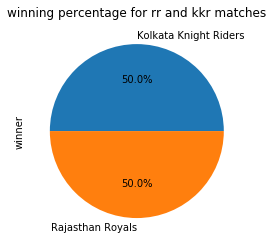

In [70]:
#get matches between rr and kkr
rr_kkr_matches = matches[((matches.team1=='Rajasthan Royals')&(matches.team2=='Kolkata Knight Riders'))|((matches.team2=='Rajasthan Royals')&(matches.team1=='Kolkata Knight Riders'))]

#getting wins count
rr_kkr_matches.winner.value_counts().plot(kind='pie', autopct='%1.1f%%', title="winning percentage for rr and kkr matches")

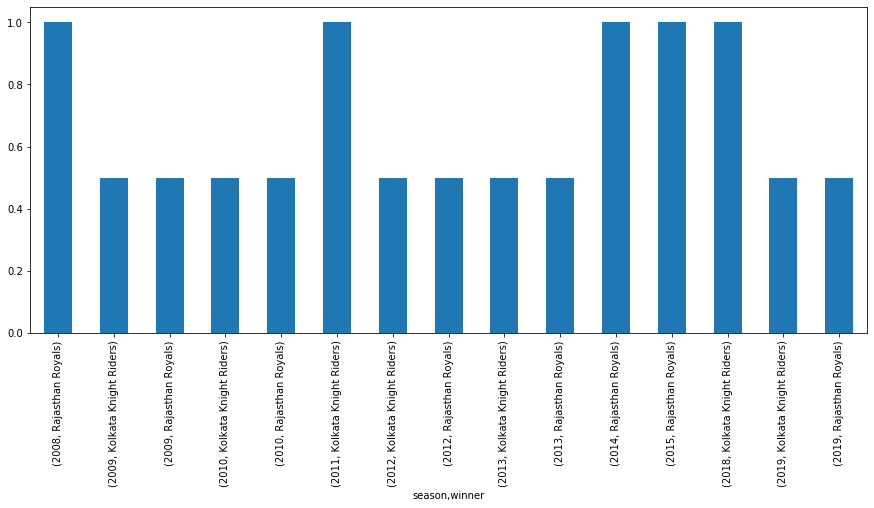

In [71]:
#getting matches between rr nad kkr matchwise
rr_kkr_matches.groupby('season')['winner'].value_counts(normalize=True).plot(kind='bar', figsize=(15,6))

In [72]:
def get_season_winpercent(team_name):
    """
    takes team name as input and returns season wise winning percent
    """

    #count matches played by rr
    get_matches = matches[(matches.team1==team_name)|(matches.team2==team_name)]

    #getting matches played by team per season
    matches_played = get_matches.groupby('season')['id'].count().reset_index()
    matches_played = matches_played.rename(columns={'id': 'tot_matches_played' })

    #getting matches won by team per season
    matches_won = matches[matches.winner==team_name].groupby('season')['id'].count().reset_index()
    matches_won = matches_won.rename(columns={'id': 'tot_matches_won' })

    matches_wins = matches_played.merge(matches_won, on='season')
    matches_wins['winning_percent'] = matches_wins.tot_matches_won/matches_wins.tot_matches_played*100
    return matches_wins[['season', 'winning_percent']]

In [73]:
#get winning percent of rr per season
rr_winp = get_season_winpercent('Rajasthan Royals')

#get winning percent of kkr per season
kkr_winp = get_season_winpercent('Kolkata Knight Riders')


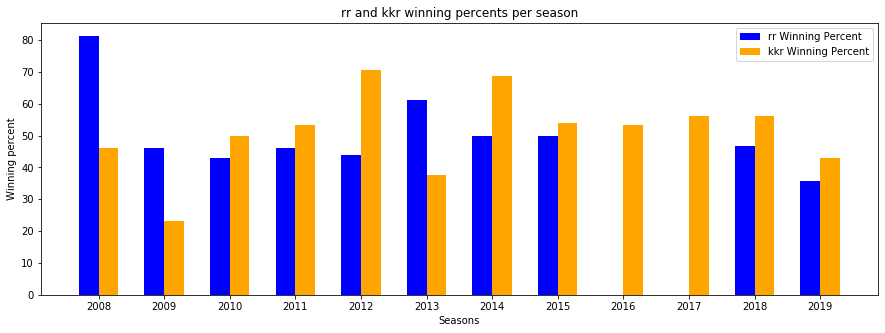

In [74]:
#checking visually
width=0.30
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(rr_winp.season-width/2, rr_winp.winning_percent, width , color='b', label='rr Winning Percent')
ax.bar(kkr_winp.season+width/2, kkr_winp.winning_percent, width,  color='orange', label='kkr Winning Percent')
plt.xlabel("Seasons")
plt.ylabel("Winning percent")
plt.title("rr and kkr winning percents per season")
plt.xticks(np.arange(2008,2020))
plt.legend()
plt.show()

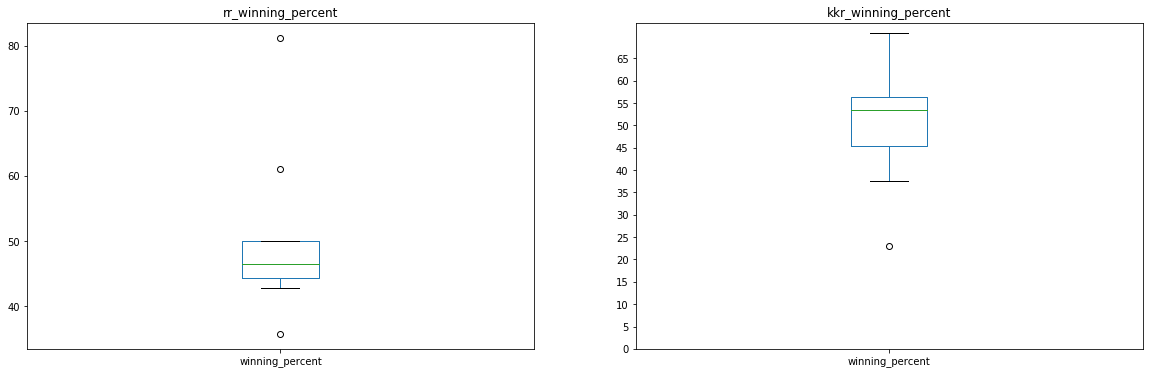

In [75]:
#checking visually
fig, ax = plt.subplots(1,2, figsize=(20,6))
rr_winp.winning_percent.plot('box', ax=ax[0], title='rr_winning_percent')
kkr_winp.winning_percent.plot('box', ax=ax[1], title='kkr_winning_percent')
plt.yticks(ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60,65]);

**Inference:**
    If we check season wise KKR seems to have higher winning percent than RR even if check the overall winnin average KKR seems to be way higher. 

###  2. How many wickets in total were taken in todays match? 

In [17]:
#get all matches between rr and kkr
rr_kkr_all = deliveries[((deliveries.bowling_team=='Rajasthan Royals')&(deliveries.batting_team=='Kolkata Knight Riders'))|((deliveries.bowling_team=='Kolkata Knight Riders')&(deliveries.batting_team=='Rajasthan Royals'))]

In [19]:
#get matchwise wicket total
match_total_wickets = matchwise_wickets_total(rr_kkr_all)

#get basic stats
match_total_wickets['wicket_count'].describe()

count    20.000000
mean     12.200000
std       3.334035
min       5.000000
25%      11.000000
50%      12.000000
75%      15.000000
max      17.000000
Name: wicket_count, dtype: float64

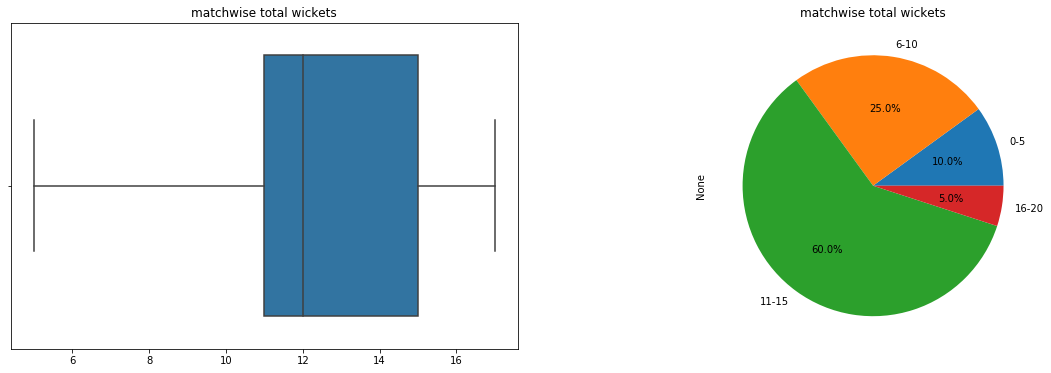

In [20]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('matchwise total wickets')
sns.boxplot(match_total_wickets['wicket_count'].values, ax=ax[0])

pd.cut(match_total_wickets['wicket_count'].values, bins=[0,6, 11, 16, 21], labels=['0-5', '6-10', '11-15', '16-20']).value_counts().plot("pie", autopct='%1.1f%%', title='matchwise total wickets', ax=ax[1]);

**Inference:**
    If we check overall wickets taken per match on average its around 12 wickets and also the probability indicates overall wickets in match will be between 11-15.

## 3. Which batsman will have the highest (# of runs scored through boundaries) to (total runs scored) ration in the match? 

Consider only those players who play more than 10 balls. If 2 players end up with the same ratio then the batsman with a higher strike rate will be chosen. If this also remains same for 2 batsman, then the one who scores more 6s off the bowler with a lesser economy rate will be selected as the answer. Even if this turns out to be the same, then other metrics and tie breakers will be considered and the answer decided by Widhya will be "FINAL". 

In [62]:
# rr_kkr_all.head()

In [172]:
# df = rr_kkr_all.copy()

#get batsman who player more than 10 balls atleast
batsman_atleast_10ball = matchwise_batsman_ballsplayed(rr_kkr_all)[matchwise_batsman_ballsplayed(rr_kkr_all).ball>10]

# get ratio : (# of runs scored through boundaries) to (total runs scored) ration in the match
result = matchwise_batsman_boundaries(rr_kkr_all).merge(matchwise_batsman_totalruns(rr_kkr_all), on=['match_id', 'batsman'], suffixes=['_boundaries', '_total']).merge(batsman_atleast_10ball, on=['match_id', 'batsman'])

# get required ratio
result['ratio'] = result['total_boundary_runs']/result['batsman_runs']

#adding strike rate to result df
result = result.merge(matchwise_batsman_strikerate(rr_kkr_all), on=['match_id', 'batsman'])

# get person who scored highest per match

s_samson_count = []
kl_rahul_counts = []
c_gayle_count = []
s_smith = []
r_uthappa = []
j_butler = []
others = []
counts = {}



d = result.groupby('batsman').median().sort_values(['ratio','strike_rate'])

d.head(20)

,match_id,total_boundary_runs,boundary_count,batsman_runs,ball,ratio,strike_rate
batsman,,,,,,,
SK Warne,168.0,4.0,1.0,18.0,29.0,0.222222,62.0690
H Klaasen,7951.0,4.0,1.0,18.0,18.0,0.222222,100.0000
Niraj Patel,168.0,4.0,1.0,14.0,22.0,0.285714,63.6360
AJ Finch,227.0,6.0,1.0,21.0,21.0,0.285714,100.0000
AD Mascarenhas,126.0,8.0,2.0,27.0,28.0,0.296296,96.4290
SP Goswami,318.0,9.0,2.0,23.5,20.5,0.382246,115.0720
LR Shukla,147.0,14.0,3.0,30.5,30.0,0.403846,101.0640
JH Kallis,374.5,13.0,3.0,32.0,34.0,0.405670,95.7895
RA Jadeja,123.0,11.0,2.5,23.5,20.0,0.415584,117.5000


In [164]:
# df = rr_kkr_all.copy()

#get batsman who player more than 10 balls atleast
batsman_atleast_10ball = matchwise_batsman_ballsplayed(rr_kkr_all)[matchwise_batsman_ballsplayed(rr_kkr_all).ball>10]

# get ratio : (# of runs scored through boundaries) to (total runs scored) ration in the match
result = matchwise_batsman_boundaries(rr_kkr_all).merge(matchwise_batsman_totalruns(rr_kkr_all), on=['match_id', 'batsman'], suffixes=['_boundaries', '_total']).merge(batsman_atleast_10ball, on=['match_id', 'batsman']).merge(matchwise_batsman_scored123(rr_kkr_all), on=['match_id', 'batsman'])

# # get required ratio
result['ratio'] = (result['total_boundary_runs'] - result['total_scored123_runs'])/result['batsman_runs']

# filtering rows where batsman play more than 10 balls
result = result.merge(matchwise_batsman_strikerate(rr_kkr_all), on=['match_id', 'batsman'])

# result.shape

In [166]:
# players = {i : [] for i in result.batsman.unique().tolist() }
players = {}

for id in result.match_id.unique():
    df1 = result[result.match_id==id].sort_values(by=['ratio', 'strike_rate'], ascending=False)
    display(df1)
#     l = df1['batsman'].tolist()
#     play = {i : l.index(i) for i in l }
#     players.update(play)
# #     for j in l:
# #         players[j] = players[j].append(l.index(j))
        

,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
3,78,M Kaif,18,4,21,19,3,3,0.714286,110.526
0,78,AB Agarkar,16,3,20,15,4,3,0.600000,133.333
5,78,SA Asnodkar,46,11,60,35,14,13,0.533333,171.429
7,78,YK Pathan,36,8,55,33,19,16,0.309091,166.667
6,78,SC Ganguly,28,6,51,41,23,19,0.098039,124.390
4,78,RA Jadeja,18,4,33,20,15,11,0.090909,165.000
2,78,DJ Hussey,16,3,42,32,26,22,-0.238095,131.250
1,78,DB Das,4,1,11,13,7,6,-0.272727,84.615


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
14,105,Salman Butt,20,5,24,22,4,4,0.666667,109.091
15,105,YK Pathan,38,8,48,20,10,7,0.583333,240.000
13,105,SR Watson,14,3,19,15,5,4,0.473684,126.667
9,105,DJ Hussey,8,2,11,15,3,3,0.454545,73.333
10,105,GC Smith,16,4,24,24,8,7,0.333333,100.000
8,105,DB Das,16,3,31,20,15,13,0.032258,155.000
11,105,M Kaif,16,4,34,32,18,14,-0.058824,106.250
12,105,SC Ganguly,14,3,32,34,18,16,-0.125000,94.118


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
22,126,YK Pathan,52,11,60,26,8,6,0.733333,230.769
18,126,CH Gayle,44,9,54,44,10,9,0.629630,122.727
17,126,AS Raut,16,3,21,17,5,4,0.523810,123.529
21,126,SC Ganguly,28,6,46,34,18,16,0.217391,135.294
23,126,Yashpal Singh,12,3,20,18,8,7,0.200000,111.111
20,126,LR Shukla,4,1,13,13,9,8,-0.384615,100.000
16,126,AD Mascarenhas,8,2,27,28,19,17,-0.407407,96.429
19,126,GC Smith,4,1,15,21,11,8,-0.466667,71.429


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
24,168,DJ Hussey,8,2,9,13,1,1,0.777778,69.231
26,168,NV Ojha,18,3,22,13,4,3,0.636364,169.231
25,168,LR Shukla,24,5,48,47,24,19,0.000000,102.128
30,168,YK Pathan,4,1,9,16,5,5,-0.111111,56.250
28,168,RA Jadeja,4,1,14,20,10,8,-0.428571,70.000
27,168,Niraj Patel,4,1,14,22,10,8,-0.428571,63.636
29,168,SK Warne,4,1,18,29,14,12,-0.555556,62.069


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
35,187,FY Fazal,24,6,31,24,7,6,0.548387,129.167
37,187,NV Ojha,20,5,27,19,7,7,0.481481,142.105
36,187,MK Tiwary,8,2,11,13,3,3,0.454545,84.615
38,187,OA Shah,12,2,19,18,7,7,0.263158,105.556
34,187,CA Pujara,16,4,29,25,13,13,0.103448,116.000
32,187,AC Voges,20,4,37,22,17,13,0.081081,168.182
40,187,YK Pathan,8,2,15,14,7,6,0.066667,107.143
31,187,AA Jhunjhunwala,20,5,45,37,25,23,-0.111111,121.622
39,187,SC Ganguly,12,3,33,29,21,15,-0.272727,113.793
33,187,BJ Hodge,12,3,36,34,24,21,-0.333333,105.882


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
46,227,SR Watson,34,8,44,26,10,9,0.545455,169.231
45,227,SC Ganguly,56,13,75,54,19,17,0.493333,138.889
44,227,NV Ojha,12,3,18,22,6,6,0.333333,81.818
42,227,CA Pujara,26,6,45,40,19,18,0.155556,112.500
43,227,FY Fazal,4,1,13,13,9,9,-0.384615,100.000
41,227,AJ Finch,6,1,21,21,15,13,-0.428571,100.000


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
47,246,AG Paunikar,8,2,9,18,1,1,0.777778,50.000
49,246,G Gambhir,50,12,75,44,25,23,0.333333,170.455
51,246,LRPL Taylor,20,4,35,27,15,12,0.142857,129.630
53,246,SR Watson,12,2,22,13,10,9,0.090909,169.231
48,246,AL Menaria,14,3,27,22,13,12,0.037037,122.727
50,246,JH Kallis,40,9,80,66,40,34,0.000000,121.212
52,246,R Dravid,16,4,35,36,19,16,-0.085714,97.222


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
58,251,MK Tiwary,22,5,30,26,8,7,0.466667,115.385
59,251,SR Watson,8,2,11,13,3,3,0.454545,84.615
54,251,AG Paunikar,8,2,15,15,7,6,0.066667,100.000
55,251,AL Menaria,10,2,21,19,11,11,-0.047619,110.526
56,251,AS Raut,4,1,11,15,7,6,-0.272727,73.333
57,251,G Gambhir,12,3,35,39,23,19,-0.314286,89.744


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
61,314,B Lee,20,4,25,12,5,4,0.600000,208.333
66,314,R Dravid,20,4,26,24,6,6,0.538462,108.333
65,314,OA Shah,14,3,23,11,9,6,0.217391,209.091
60,314,AL Menaria,22,5,40,31,18,15,0.100000,129.032
62,314,BJ Hodge,24,5,44,29,20,16,0.090909,151.724
63,314,DB Das,6,1,12,14,6,5,0.000000,85.714
64,314,MK Tiwary,28,7,59,50,31,27,-0.050847,118.000
68,314,YK Pathan,6,1,15,16,9,8,-0.200000,93.750
67,314,SP Goswami,8,2,23,19,15,13,-0.304348,121.053


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
71,322,G Gambhir,8,2,11,12,3,3,0.454545,91.667
76,322,R Dravid,20,5,28,27,8,7,0.428571,103.704
69,322,AM Rahane,12,3,19,16,7,7,0.263158,118.750
70,322,BJ Hodge,6,1,12,11,6,5,0.000000,109.091
73,322,MK Tiwary,10,2,24,18,14,9,-0.166667,133.333
77,322,SP Goswami,10,2,24,22,14,13,-0.166667,109.091
74,322,MS Bisla,12,3,29,32,17,15,-0.172414,90.625
75,322,OA Shah,12,3,31,36,19,17,-0.225806,86.111
72,322,JH Kallis,12,3,31,38,19,18,-0.225806,81.579


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
86,389,STR Binny,12,3,14,11,2,2,0.714286,127.273
85,389,SR Watson,4,1,5,11,1,1,0.600000,45.455
80,389,DH Yagnik,10,2,16,11,6,4,0.250000,145.455
79,389,BJ Hodge,28,7,46,31,18,16,0.217391,148.387
81,389,EJG Morgan,30,6,51,39,21,16,0.176471,130.769
78,389,AM Rahane,18,4,36,34,18,17,0.000000,105.882
84,389,R Dravid,8,2,17,20,9,7,-0.058824,85.000
82,389,G Gambhir,10,2,22,23,12,9,-0.090909,95.652
83,389,MK Tiwary,4,1,14,13,10,7,-0.428571,107.692


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
89,427,MS Bisla,22,5,29,26,7,5,0.517241,111.538
93,427,YK Pathan,30,6,49,36,19,18,0.224490,136.111
91,427,SR Watson,16,4,35,39,19,17,-0.085714,89.744
88,427,JH Kallis,14,3,33,30,19,17,-0.151515,110.000
92,427,SV Samson,16,3,40,36,24,23,-0.200000,111.111
90,427,OA Shah,8,2,24,23,16,15,-0.333333,104.348
87,427,G Gambhir,4,1,12,16,8,7,-0.333333,75.000


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
101,476,SV Samson,16,4,20,20,4,4,0.600000,100.000
100,476,SR Watson,24,6,39,27,15,13,0.230769,144.444
97,476,MK Pandey,16,3,27,15,11,9,0.185185,180.000
98,476,SA Yadav,18,4,31,21,13,10,0.161290,147.619
94,476,AM Rahane,30,7,72,60,42,32,-0.166667,120.000
102,476,Shakib Al Hasan,12,3,31,21,19,14,-0.225806,147.619
95,476,G Gambhir,16,4,45,45,29,23,-0.288889,100.000
99,476,SPD Smith,8,2,24,14,16,11,-0.333333,171.429
96,476,JH Kallis,4,1,13,17,9,7,-0.384615,76.471


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
107,482,SR Watson,20,4,31,21,11,9,0.290323,147.619
103,482,AM Rahane,18,4,30,22,12,9,0.200000,136.364
106,482,RV Uthappa,38,8,65,52,27,25,0.169231,125.000
104,482,G Gambhir,30,7,54,34,24,19,0.111111,158.824
105,482,KK Nair,22,5,44,36,22,17,0.000000,122.222
109,482,Shakib Al Hasan,10,2,21,15,11,10,-0.047619,140.000
108,482,SV Samson,12,3,37,32,25,21,-0.351351,115.625


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
116,570,UT Yadav,22,5,24,13,2,2,0.833333,184.615
110,570,AD Russell,28,6,37,22,9,8,0.513514,168.182
111,570,AM Rahane,24,5,37,22,13,10,0.297297,168.182
114,570,SR Watson,66,14,104,62,38,33,0.269231,167.742
115,570,Shakib Al Hasan,8,2,13,14,5,5,0.230769,92.857
117,570,YK Pathan,26,6,44,39,18,17,0.181818,112.821
113,570,SPD Smith,8,2,14,11,6,6,0.142857,127.273
112,570,MK Pandey,12,3,21,21,9,9,0.142857,100.000


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
125,7908,RV Uthappa,36,8,49,37,13,13,0.469388,132.432
118,7908,AM Rahane,26,6,36,19,10,10,0.444444,189.474
126,7908,SP Narine,26,6,36,25,10,8,0.444444,144.000
120,7908,D Short,26,6,45,43,19,17,0.155556,104.651
124,7908,RA Tripathi,8,2,15,11,7,7,0.066667,136.364
122,7908,KD Karthik,20,4,42,23,22,16,-0.047619,182.609
119,7908,BA Stokes,6,1,14,11,8,7,-0.142857,127.273
123,7908,N Rana,14,3,36,28,22,21,-0.222222,128.571
121,7908,JC Buttler,8,2,28,21,20,15,-0.428571,133.333


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
133,7942,RA Tripathi,22,5,27,15,5,4,0.629630,180.000
129,7942,JC Buttler,32,7,40,23,8,8,0.600000,173.913
130,7942,JD Unadkat,18,4,26,18,8,8,0.384615,144.444
132,7942,N Rana,14,3,22,18,8,7,0.272727,122.222
131,7942,KD Karthik,26,6,42,31,16,14,0.238095,135.484
128,7942,CA Lynn,26,6,45,42,19,18,0.155556,107.143
127,7942,AM Rahane,4,1,11,12,7,4,-0.272727,91.667


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
134,7951,AD Russell,42,8,52,27,10,10,0.615385,192.593
139,7951,RA Tripathi,16,3,20,13,4,4,0.600000,153.846
140,7951,S Gill,18,4,28,17,10,9,0.285714,164.706
141,7951,SV Samson,28,6,50,38,22,18,0.120000,131.579
138,7951,KD Karthik,28,6,52,38,24,21,0.076923,136.842
135,7951,AM Rahane,22,5,47,42,25,22,-0.063830,111.905
136,7951,CA Lynn,8,2,19,23,11,9,-0.157895,82.609
137,7951,H Klaasen,4,1,18,18,14,12,-0.555556,100.000


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
142,11312,CA Lynn,42,9,51,32,9,9,0.647059,159.375
146,11312,SP Narine,42,9,52,27,10,8,0.615385,192.593
143,11312,JC Buttler,26,6,39,35,13,12,0.333333,111.429
144,11312,RV Uthappa,16,3,26,16,10,8,0.230769,162.500
147,11312,SPD Smith,34,8,79,61,45,37,-0.139241,129.508
145,11312,S Gill,4,1,11,11,7,7,-0.272727,100.000


,match_id,batsman,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
151,11334,KD Karthik,82,16,101,52,19,19,0.623762,194.231
149,11334,AM Rahane,26,6,34,21,8,7,0.529412,161.905
150,11334,J Archer,20,4,28,13,8,8,0.428571,215.385
153,11334,R Parag,32,7,50,34,18,16,0.280000,147.059
152,11334,N Rana,16,4,26,26,10,9,0.230769,100.000
154,11334,S Gill,8,2,14,14,6,5,0.142857,100.000
156,11334,SV Samson,12,2,22,15,10,8,0.090909,146.667
155,11334,STR Binny,6,1,12,12,6,4,0.000000,100.000
148,11334,AD Russell,6,1,14,14,8,8,-0.142857,100.000


In [167]:
l = result.batsman.unique().tolist()
players = {i : l.count(i) for i in l  }
result['batsman']

0          AB Agarkar
1              DB Das
2           DJ Hussey
3              M Kaif
4           RA Jadeja
5         SA Asnodkar
6          SC Ganguly
7           YK Pathan
8              DB Das
9           DJ Hussey
10           GC Smith
11             M Kaif
12         SC Ganguly
13          SR Watson
14        Salman Butt
15          YK Pathan
16     AD Mascarenhas
17            AS Raut
18           CH Gayle
19           GC Smith
20          LR Shukla
21         SC Ganguly
22          YK Pathan
23      Yashpal Singh
24          DJ Hussey
25          LR Shukla
26            NV Ojha
27        Niraj Patel
28          RA Jadeja
29           SK Warne
            ...      
127         AM Rahane
128           CA Lynn
129        JC Buttler
130        JD Unadkat
131        KD Karthik
132            N Rana
133       RA Tripathi
134        AD Russell
135         AM Rahane
136           CA Lynn
137         H Klaasen
138        KD Karthik
139       RA Tripathi
140            S Gill
141       

In [168]:
result.groupby('batsman').count().sort_values(by='match_id', ascending=False)

,match_id,total_boundary_runs,boundary_count,batsman_runs,ball,total_scored123_runs,scored123_count,ratio,strike_rate
batsman,,,,,,,,,
AM Rahane,9,9,9,9,9,9,9,9,9
SR Watson,9,9,9,9,9,9,9,9,9
YK Pathan,8,8,8,8,8,8,8,8,8
G Gambhir,7,7,7,7,7,7,7,7,7
MK Tiwary,5,5,5,5,5,5,5,5,5
SV Samson,5,5,5,5,5,5,5,5,5
SC Ganguly,5,5,5,5,5,5,5,5,5
R Dravid,4,4,4,4,4,4,4,4,4
OA Shah,4,4,4,4,4,4,4,4,4


**Inference:**
  If we check as per conditions and calculate ratio and take median as per matches higher chance for SPD smith and tewatia to get a higher ratio than other players.

### 4. What will be Jofra Archers economy rate and how many boundaries will he give away in his 4 overs?

    * Economy Rate <=7.5, Boundaries <=4    
    * Economy Rate <=7.5, Boundaries > 4
    * Economy Rate >7.5, Boundaries <=4
    * Economy Rate >7.5, Boundaries >4

In [39]:
#get all rows for first 4 overs.
rr_kkr_o14 = rr_kkr_all[rr_kkr_all.over.isin(range(1,5))]

#get economy rate of archer
rr_kkr_economyrate = economy_rate(rr_kkr_o14)

#get j archers economy rate
jarcher_economy_rate = rr_kkr_economyrate[rr_kkr_economyrate.bowler=='J Archer']

jarcher_economy_rate['economy_rate'].describe()

count     3.000000
mean      7.666667
std       3.511885
min       4.000000
25%       6.000000
50%       8.000000
75%       9.500000
max      11.000000
Name: economy_rate, dtype: float64

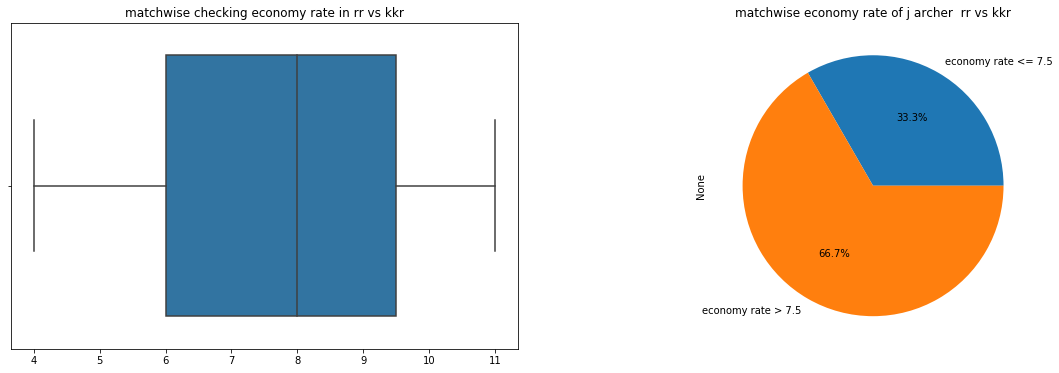

In [42]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('matchwise checking economy rate in rr vs kkr')
sns.boxplot(jarcher_economy_rate['economy_rate'].values, ax=ax[0])

pd.cut(jarcher_economy_rate['economy_rate'].values, bins=[0,7.6, 12], labels=['economy rate <= 7.5', 'economy rate > 7.5']).value_counts().plot("pie", autopct='%1.1f%%', title='matchwise economy rate of j archer  rr vs kkr', ax=ax[1]);

In [47]:
#get boundary runs given by the bowler
bowler_boundaries = matchwise_bowler_gaveboundaries(rr_kkr_o14)

#get j archers boundaries per match
jarcher_boundaries = bowler_boundaries[bowler_boundaries.bowler=='J Archer']

jarcher_boundaries['boundary_counts'].describe()

count    3.000000
mean     1.333333
std      0.577350
min      1.000000
25%      1.000000
50%      1.000000
75%      1.500000
max      2.000000
Name: boundary_counts, dtype: float64

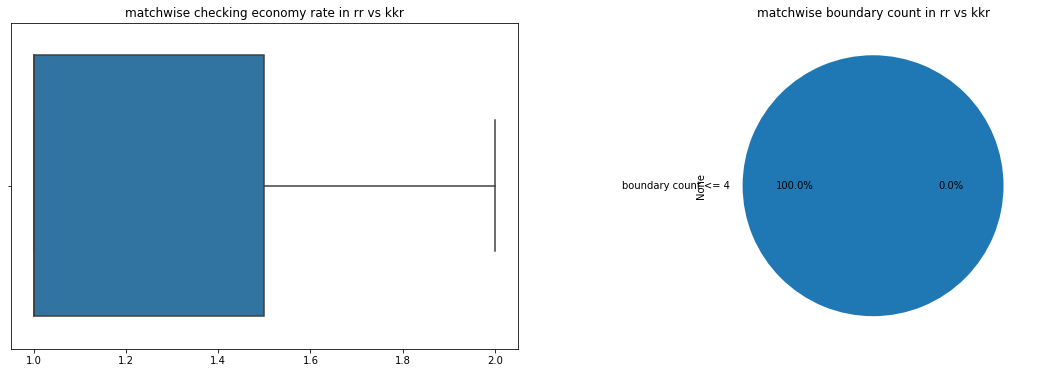

In [48]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('matchwise checking economy rate in rr vs kkr')
sns.boxplot(jarcher_boundaries['boundary_counts'].values, ax=ax[0])

pd.cut(jarcher_boundaries['boundary_counts'].values, bins=[0,5, 10], labels=['boundary count <= 4', 'boundary count > 4']).value_counts().plot("pie", autopct='%1.1f%%', title='matchwise boundary count in rr vs kkr', ax=ax[1]);

**Inference:**
    If we check average of archers economy rate matchwise we get average as more than 7 and higher probability of getting >7.5, whereas boundary counts higher probability to get is <= 4

### 5. How many bowlers in the match, from both teams, will have an economy rate of less than 8? Only those bowlers who bowl more than 1 over more be considered. If no bowler has an economy rate of less than 8, the first option will be considered as the answer.
    * 0-1
    * 2-3
    * 4-5
    * 6 or more

In [60]:
#get economy rates for all bowlers for both teams
rr_kkr_economyrate = economy_rate(rr_kkr_all)

# filter rows where overs played are > 1
rr_kkr_economyrate_og1 = rr_kkr_economyrate[rr_kkr_economyrate.over>1]

#get bowlers who have economy rate < 8
rr_kkr_economyrate_less8 = rr_kkr_economyrate_og1[rr_kkr_economyrate_og1.economy_rate < 8]

#counting number of such players who meet conditions per match
economyrate_less8_bowlercount = rr_kkr_economyrate_less8.groupby('match_id')['bowler'].count()

economyrate_less8_bowlercount.describe()



count    20.000000
mean      6.200000
std       2.142306
min       1.000000
25%       5.750000
50%       6.000000
75%       7.000000
max      11.000000
Name: bowler, dtype: float64

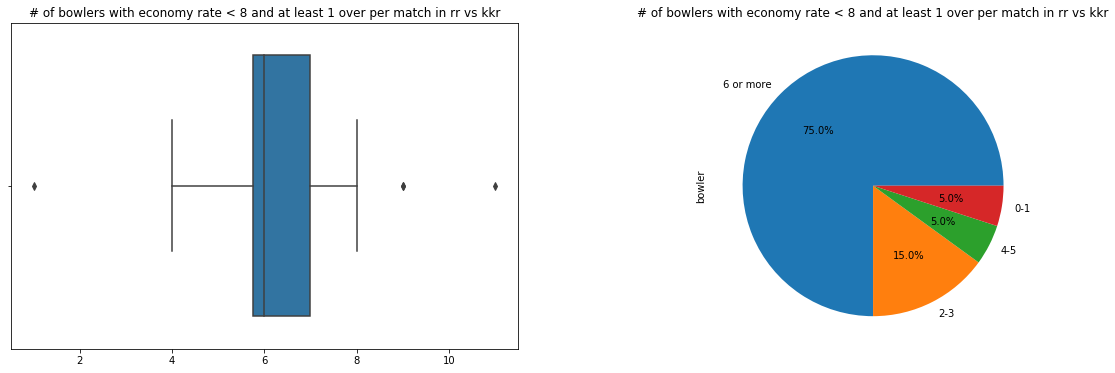

In [94]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('# of bowlers with economy rate < 8 and at least 1 over per match in rr vs kkr')
sns.boxplot(economyrate_less8_bowlercount.values, ax=ax[0])

pd.cut(economyrate_less8_bowlercount, bins=[0,2, 4, 5, 12], labels=['0-1', '2-3', '4-5', '6 or more']).value_counts().plot("pie", autopct='%1.1f%%', title='# of bowlers with economy rate < 8 and at least 1 over per match in rr vs kkr', ax=ax[1]);

**Inference:**
   

**Inference:**
    If we check number of bowlers which match condition on average we have 6 such bowlers on average matchwise and if we check probability highest probability has been highest for 6 or more such bowlers.  